In [1]:
import numpy as np
#import cupy as np
import pylab as plt
import sys, random, os
sys.path.append('/mnt/d/shell/Wind Farm Evaluator/')
import Farm_Evaluator_Vec as ev
sys.path.pop()
import pandas as pd
from numba import jit, prange

In [2]:
turb_specs    =  {   
                         'Name': 'Anon Name',
                         'Vendor': 'Anon Vendor',
                         'Type': 'Anon Type',
                         'Dia (m)': 100,
                         'Rotor Area (m2)': 7853,
                         'Hub Height (m)': 100,
                         'Cut-in Wind Speed (m/s)': 3.5,
                         'Cut-out Wind Speed (m/s)': 25,
                         'Rated Wind Speed (m/s)': 15,
                         'Rated Power (MW)': 3
                  }
turb_diam      =  turb_specs['Dia (m)']
turb_rad       =  turb_diam/2 

power_curve   =  ev.loadPowerCurve('/mnt/d/shell/Shell_Hackathon Dataset/power_curve.csv')
n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = ev.preProcessing(power_curve)

wind_inst = []
with os.scandir('/mnt/d/shell/Shell_Hackathon Dataset/Wind Data/') as entries:  
        for entry in entries:
            print(entry.name)
            wind_inst.append(ev.binWindResourceData(entry))


2017_2007.csv
combined.csv
wind_data_2007.csv
wind_data_2008.csv
wind_data_2009.csv
wind_data_2013.csv
wind_data_2014.csv
wind_data_2015.csv
wind_data_2017.csv


In [3]:
ens_N = 2000
N = 14
sigma = 0.1125
m_r = 0.1
num_steps = 2000

In [4]:
#Grid creation and populating Ensemble
xpos = [x+450 for x in range(0, 3100, int(3100/7))]
xpos.pop()
xpos.append(3550)
print(xpos)
norm_grid_coarse = []
for i in range(8):
    for j in range(8):
        norm_grid_coarse.append([xpos[i]/4000, xpos[j]/4000])

ens_pos = []
for xx in range(ens_N):
    L= random.sample(norm_grid_coarse, N)    
    ens_pos.append(L)
norm_grid_coarse = np.array(norm_grid_coarse)

[450, 892, 1334, 1776, 2218, 2660, 3102, 3550]


In [5]:
#creating fine mesh
xpos = [x+450 for x in range(0, 3100, int(3100/2000))]
xpos.pop()
xpos.append(3950)
print(len(xpos))
norm_grid_fine = []
for i in range(len(xpos)):
    for j in range(len(xpos)):
        norm_grid_fine.append([xpos[i]/4000, xpos[j]/4000])


3100


In [9]:
# 7, 13, 8, 9, 14, 17, 15, 17_7

#calulation of energy of N positions of windfarms

boundary_positions = np.array([[0.9875, 0.0125], [0.0125, 0.9875], [0.77025, 0.9875], [0.9875, 0.9875], [0.9866496781493791, 0.769399678149379],
                                [0.9875, 0.8785], [0.4455, 0.0125], [0.12075, 0.0125], [0.0125, 0.662], [0.9875, 0.229], [0.33725, 0.0125],
                                [0.229, 0.9875], [0.55375, 0.0125], [0.8785, 0.0125], [0.55375, 0.9875], [0.0125, 0.55375], [0.229, 0.0125], 
                                [0.33725, 0.9875], [0.9875, 0.662], [0.7692844171348504, 0.013013686970533804], [0.12075, 0.9875], [0.0125, 0.8785],
                                [0.8785, 0.9875], [0.013002106549573164, 0.22849789345042684], [0.0125, 0.0125], [0.662, 0.9875], [0.9875, 0.33725],
                                [0.662, 0.0125], [0.9875, 0.12075], [0.0125, 0.4455], [0.9875, 0.4455], [0.4455, 0.9875], [0.0125, 0.33725], 
                                [0.9875, 0.55375], [0.013350321850620947, 0.77025], [0.0125, 0.12075]])

def avg_aep(microstate):  
    turb_coords = np.concatenate((microstate, boundary_positions), axis = 0)
    turb_coords = turb_coords * 4000
    return ev.getAEP(turb_rad, turb_coords, power_curve, wind_inst[0], 
                                         n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)  
    
# sort Ensemble with respect to the energy in decreaing order
@jit(parallel = True)
def sortby_energy(ensemble, energy_array, begin = 0, end = ens_N):
    for i in prange(begin, end):
        energy_array[i] = avg_aep(ensemble[i])
    indices = energy_array.argsort()
    ensemble = ensemble[indices[::-1]]
    return ensemble, energy_array

#select best out of the ensemble at each step
@jit(parallel = True)
def selection(ensemble, boolean_val):
    if(boolean_val):
        for i in prange(3, 100):
            indexarr = np.random.choice(len(norm_grid_coarse), size=N, replace = False)
            ensemble[i] = norm_grid_coarse[indexarr, :]
    return ensemble

@jit
def crossover(ensemble):
    for k in range(100, ens_N):
        indexes = np.random.choice(100, 2, replace = False)
        cross_array = np.concatenate((ensemble[indexes[0]], ensemble[indexes[1]]), axis = 0)
        cross_array = pd.DataFrame(cross_array).drop_duplicates().values
        while(True):
          indexarr = np.random.choice(len(cross_array), size=N, replace = False)
          new_contender = cross_array[indexarr, :]
          condition = True
          for i in prange(N-1):
              for j in range(i+1, N):
                  min_dist_sq = ((new_contender[i][0] - new_contender[j][0]) ** 2 + (new_contender[i][1] - new_contender[j][1]) ** 2)
                  if (min_dist_sq < 0.01):
                      condition *= False
          if(condition):
            ensemble[k] = new_contender
            break
    return ensemble

@jit
def mutation(ensemble, rate):
    count1 = 1
    count2 = 1
    indexes = np.random.randint(1, ens_N, size = rate)
    for index in indexes:
        while(True):           
            ind = random.randint(0, N-1)
            temp = ensemble[index, ind]
            ran_num = random.uniform(0, 1)
            if (ran_num < 0.5):
                new = norm_grid_fine[np.random.randint(0, 3100*3100)]
                condition = True
                for i in prange(N):
                    if (i != ind):      
                        min_dist_sq = (new[0] - ensemble[index, i, 0])** 2 + (new[1] - ensemble[index, i, 1])** 2
                        if (min_dist_sq < 0.01):
                            condition *= False
                if(condition):
                    count1 += 1
                    ensemble[index, ind] = new
                    break

            else:
                rand_num = random.randint(0, 7)
                new = np.array([ensemble[index, ind, 0], ensemble[index, ind, 1]]) + local_search_array[rand_num]
                box_cond = min(new[0], new[1]) > sigma and max(new[0], new[1]) < 1.0 - sigma
                condition = True
                for i in prange(N):
                    if (i != ind):      
                        min_dist_sq = (new[0] - ensemble[index, i, 0])** 2 + (new[1] - ensemble[index, i, 1])** 2
                        if (min_dist_sq < 0.01):
                            condition *= False
                if(condition and box_cond): 
                    count2 += 1           
                    ensemble[index, ind] = new
                    break
    return ensemble, count1/(count1+count2)


In [10]:
delta = 0.1105
local_search_array = np.array([ 
                               [-delta, delta],  [0, delta],  [delta, delta],
                               [-delta, 0],                   [delta, 0],
                               [-delta, -delta], [0, -delta], [delta, -delta]            
                                                                              ])
ensemble_of_pos = np.array(ens_pos)
overall_best_pos = np.zeros((N,2))
energy_array = np.zeros(ens_N)
enemble_average_energy = 0
overall_best_en = 50
for step in range(num_steps):
    if (step%100 == 0):
        zz_z = np.concatenate((overall_best_pos, boundary_positions), axis = 0)
        print(step, delta, overall_best_en, zz_z.tolist())
    if (overall_best_en - enemble_average_energy < 0.05):
        delta *= 0.99
        local_search_array = np.array([ [-delta, delta],  [0, delta],  [delta, delta],
                                        [-delta, 0],           [delta, 0], 
                                        [-delta, -delta], [0, -delta], [delta, -delta] ])
        ensemble_of_pos, energy_array = sortby_energy(ensemble_of_pos, energy_array)
        ensemble_of_pos = selection(ensemble_of_pos, True)
        zz_z = np.concatenate((overall_best_pos, boundary_positions), axis = 0)
        print('#', step, delta, overall_best_en, zz_z.tolist())
    else:
        ensemble_of_pos, energy_array  = sortby_energy(ensemble_of_pos, energy_array )
        ensemble_of_pos = selection(ensemble_of_pos, False)
    ensemble_of_pos = crossover(ensemble_of_pos)
    ensemble_of_pos, energy_array  = sortby_energy(ensemble_of_pos, energy_array, begin = 100, end = ens_N)
    ensemble_of_pos, count_m = mutation(ensemble_of_pos, int(m_r * ens_N * N))
    enemble_average_energy = 0
    for position in ensemble_of_pos:
        zz = avg_aep(position)
        enemble_average_energy += zz   
        if (zz > overall_best_en):
            overall_best_en = zz
            overall_best_pos = position.copy() 
        
    enemble_average_energy = enemble_average_energy / ens_N
        
    print(step, count_m, delta, enemble_average_energy, overall_best_en)

#change mutation rate

, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.9875, 0.0125], [0.0125, 0.9875], [0.77025, 0.9875], [0.9875, 0.9875], [0.9866496781493791, 0.769399678149379], [0.9875, 0.8785], [0.4455, 0.0125], [0.12075, 0.0125], [0.0125, 0.662], [0.9875, 0.229], [0.33725, 0.0125], [0.229, 0.9875], [0.55375, 0.0125], [0.8785, 0.0125], [0.55375, 0.9875], [0.0125, 0.55375], [0.229, 0.0125], [0.33725, 0.9875], [0.9875, 0.662], [0.7692844171348504, 0.013013686970533804], [0.12075, 0.9875], [0.0125, 0.8785], [0.8785, 0.9875], [0.013002106549573164, 0.22849789345042684], [0.0125, 0.0125], [0.662, 0.9875], [0.9875, 0.33725], [0.662, 0.0125], [0.9875, 0.12075], [0.0125, 0.4455], [0.9875, 0.4455], [0.4455, 0.9875], [0.0125, 0.33725], [0.9875, 0.55375], [0.013350321850620947, 0.77025], [0.0125, 0.12075]]
0 0.4985754985754986 0.1105 551.373747662201 553.3006796264649
1 0.4672364672364672 0.1105 552.0837654382326 553.4176048278808
2 0.48860398

KeyboardInterrupt: 

557.1266967773438
[[0.577, 0.82825], [0.83925, 0.19875], [0.3895, 0.40175], [0.198, 0.1625], [0.27525, 0.6165], [0.28, 0.40125], [0.3175, 0.119], [0.60475, 0.61025], [0.71475, 0.3915], [0.8815, 0.6805], [0.6065, 0.3975], [0.25475, 0.745], [0.389, 0.7195], [0.49600000000000005, 0.3975], [0.9875, 0.0125], [0.0125, 0.9875], [0.77025, 0.9875], [0.9875, 0.9875], [0.9866496781493791, 0.769399678149379], [0.9875, 0.8785], [0.4455, 0.0125], [0.12075, 0.0125], [0.0125, 0.662], [0.9875, 0.229], [0.33725, 0.0125], [0.229, 0.9875], [0.55375, 0.0125], [0.8785, 0.0125], [0.55375, 0.9875], [0.0125, 0.55375], [0.229, 0.0125], [0.33725, 0.9875], [0.9875, 0.662], [0.7692844171348504, 0.013013686970533804], [0.12075, 0.9875], [0.0125, 0.8785], [0.8785, 0.9875], [0.013002106549573164, 0.22849789345042684], [0.0125, 0.0125], [0.662, 0.9875], [0.9875, 0.33725], [0.662, 0.0125], [0.9875, 0.12075], [0.0125, 0.4455], [0.9875, 0.4455], [0.4455, 0.9875], [0.0125, 0.33725], [0.9875, 0.55375], [0.01335032185062094

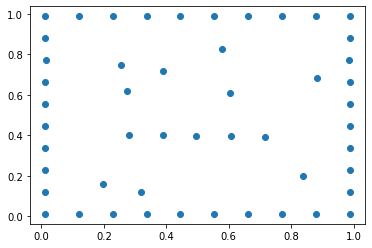

In [13]:
zz_z1 = np.concatenate((overall_best_pos, boundary_positions), axis = 0)
print(overall_best_en)
print(zz_z1.tolist())

new11 = zz_z1*4000
ev.checkConstraints(new11, turb_diam)

plt.scatter(*zip(*zz_z1)) 
plt.show()

In [12]:
xyz = overall_best_pos*4000
df = pd.DataFrame(xyz)
df.to_csv('file3.csv', index=False, header=False)